In [1]:
import matplotlib.pyplot as plt
import jax
from jax import vmap, grad, jit
import jax.numpy as jnp
import numpy as np

import scipy.io
import balltree as bt

# Use high precision

jax.config.update("jax_enable_x64", True)

def jax_build_balltree(data: jnp.ndarray, batch_idx: jnp.ndarray):
    return tuple(jnp.array(a) for a in bt.build_balltree_with_idx(np.asarray(data), np.asarray(batch_idx)))

def jax_partition_balltree(data: jnp.ndarray, batch_idx: jnp.ndarray, num_partitions: int):
    return tuple(jnp.array(a) for a in bt.partition_balltree_with_idx(np.asarray(data), np.asarray(batch_idx), num_partitions))

def jax_build_balltree_hierarchy(data, batch_idx, ball_sizes):
    data = np.asarray(data)
    batch_idx = np.asarray(batch_idx)
    
    dim = data.shape[1]
    num_layers = len(ball_sizes)
    leaves = data
    target_partitions = [max(0, int(np.log2(leaves.shape[0] / bs))) for bs in ball_sizes]
    tree_indices = []
    for i in range(num_layers):
        tree_indices.append(bt.partition_balltree_with_idx(leaves, batch_idx, target_partitions[i]))
    return tree_indices, target_partitions


def scatter_wrap(ax, q_ball, q0_ball):
    q0_mean = q0_ball.mean(axis=0)
    q_mean = q_ball.mean(axis=0)
    view_vec = q_mean - q0_mean
    view_vec = jnp.linalg.cross(view_vec, jnp.array([0, 0, 1]))
    view_vec = view_vec / jnp.linalg.norm(view_vec)# * jnp.sign(view_vec[2]) / jnp.linalg.norm(view_vec)
    up = np.array([0, 0, 1])
    r = np.cross(up, view_vec); r /= np.linalg.norm(r)  # right
    u = np.cross(view_vec, r)  # true up
    R = np.stack([r, u, -view_vec], axis=1)

    def tfm(q):
        q = jnp.einsum("ij,jk->ik", q, R)
        return q[:,0], q[:,1]

    for q,col in zip([q_ball, q0_ball], ["blue", "red"]):
        qx, qy = tfm(q)
        plot_circles(ax, qx, qy, color=col)
        #ax.scatter(qx, qy, s=50)
        
def plot_circles(ax, qx, qy, N=10, **kwargs):
    t = np.linspace(0, 2 * np.pi, N)
    x = np.outer(np.cos(t), np.ones_like(qx))
    y = np.outer(np.sin(t), np.ones_like(qy))
    for qxi,qyi in zip(qx, qy):
        ax.plot(qxi + x, qyi + y, **kwargs)

def plot_sphere(ax, q, N=10, **kwargs):
    # Make data
    u = np.linspace(0, 2 * np.pi, N)
    v = np.linspace(0, np.pi, N)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    # Plot the surface
    ax.plot_surface(q[0]+x, q[1]+y, q[2]+z, **kwargs)
    
def plot_spheres(ax, q_list, N=10, **kwargs):
    for q in q_list:
        plot_sphere(ax, q, N=N, **kwargs)

def to_mat_idx(idx):
    #return 6*np.repeat(idx, 6) + (np.arange(6*len(idx)) % 6)
    return 6*idx
    
# Load matlab file
mat = scipy.io.loadmat('../data/Y25M08D21_mobility_study_1024_par.mat')
M = jnp.array(mat["M"])
q = jnp.array(mat["q"])
P = q.shape[0]
d = q.shape[1]
batch_idx = jnp.zeros((q.shape[0],), dtype=jnp.int32)
tree_idx, _ = jax_build_balltree(q.astype(jnp.float32), batch_idx)
sizes = [2,4,8,16, 32]#,64]
target_partitions = [max(0, int(np.log2(q.shape[0] / bs))) for bs in sizes]


In [2]:
import itertools
from jax.scipy.special import sph_harm

lvl = 4
tp = target_partitions[lvl]
num_balls = 2 ** tp
size = P // num_balls

def ball_idx_to_particle_idx(j, size):
    particle_idx = np.unique(tree_idx[j*size:(j+1)*size])
    return particle_idx


def ball_pair_to_data(i, j):
    pidx_i = ball_idx_to_particle_idx(i, size)
    pidx_j = ball_idx_to_particle_idx(j, size)
    iG, jG = np.meshgrid(to_mat_idx(pidx_i), to_mat_idx(pidx_j), indexing='ij')
    return M[iG.flatten(), jG.flatten()].reshape(iG.shape), q[pidx_i, :], q[pidx_j, :]
    #return M[iG, jG], q[pidx_i, :], q[pidx_j, :]


def partitions(n, b):
    masks = np.identity(b, dtype=int)
    for c in itertools.combinations_with_replacement(masks, n): 
        yield sum(c)

def get_degrees(dim, degree):
    return np.array(list(partitions(degree, dim+1)))[:, 1:].T

def normalize(B):
    return B / jnp.linalg.norm(B, axis=0, keepdims=True)

def polynomial_basis(x, degree):
    dim = x.shape[1]
    degree_vec = get_degrees(dim, degree)
    mult_op = lambda x: jnp.prod(x[:, None] ** degree_vec, axis=0)
    return vmap(mult_op)(x)

def cartesian_to_spherical(coords):
    x, y, z = coords[0], coords[1], coords[2]
    r = jnp.sqrt(x**2 + y**2 + z**2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return r, theta, phi

def spherical_harmonics(coords, degree, order):
    # Convert Cartesian coordinates to spherical coordinates
    r, theta, phi = cartesian_to_spherical(coords)
    # Compute spherical harmonics
    Y = sph_harm(m=order, n=degree, theta=phi, phi=theta)
    return Y / r ** (degree/2)

def sph_harm_params(max_degree):
    orders = [jnp.arange(-degree, degree + 1) for degree in range(max_degree + 1)]
    degrees = [jnp.full_like(order, degree) for degree, order in zip(range(max_degree + 1), orders)]
    return jnp.concatenate(orders), jnp.concatenate(degrees)

def spherical_harmonics_basis(x, degree):
    # Compute spherical harmonics basis functions
    # This is a placeholder implementation
    orders, degrees = sph_harm_params(degree)
    Y = vmap(spherical_harmonics, (0, None, None))(x, degrees, orders)
    Y = jnp.repeat(Y, repeats=2, axis=1)
    #even_idx = (jnp.arange(Y.shape[1]) % 2 == 0)[None, :]
    #Y = (1j * Y * even_idx + Y * (1-even_idx)).real[:, 1:] # Extract real-valued spherical harmonics
    return Y

def fourier_basis(x, max_degree):
    # Compute Fourier basis functions
    # This is a placeholder implementation
    dim = x.shape[1]
    freqs = jnp.arange(-max_degree, max_degree + 1)
    tensor_freqs = jnp.array(list(itertools.product(*(freqs,) * dim)))
    mult_op = lambda x: jnp.exp(1j * jnp.sum(x[:, None] * tensor_freqs, axis=0))
    #B = vmap(mult_op)(x)
    return tensor_freqs
    

def basis(q, degree, type='polynomial'):
    # Compute the basis vectors for the given points q
    # As an example, here is a random basis
    match type:
        case 'polynomial':
            B = normalize(polynomial_basis(q, degree))
        case 'spherical_harmonics':
            B = normalize(spherical_harmonics_basis(q, degree))
    return B

def tensor_basis(q1, q2, degree):
    q1 = q1 - q1.mean(axis=0)
    q2 = q2 - q2.mean(axis=0)

    dim = q1.shape[1]
    degree_vec = get_degrees(2*dim, degree)
    mult_op = lambda x, dv: jnp.prod(x[:, None] ** dv, axis=0)
    B1 = normalize(vmap(mult_op, (0, None))(q1, degree_vec[:dim, :]))
    B2 = normalize(vmap(mult_op, (0, None))(q2, degree_vec[dim:, :]))
    return B1, B2


def frobenius(M):
    return jnp.sqrt(jnp.sum(jnp.abs(M)**2))


b = polynomial_basis(jnp.array([2., 10])[None, :], 3)
order, degree = sph_harm_params(3)
#print(order, degree)
#print(b.astype(int))
z = jnp.array([[1., 0., 0.], [0., 1., 0.]])
b = spherical_harmonics_basis(z, 3)


#print(fourier_basis(z, 3))

/tmp/ipykernel_1495604/4144105832.py:2: DeprecationWarning: jax.scipy.special.sph_harm is deprecated; use sph_harm_y instead.
  from jax.scipy.special import sph_harm
/tmp/ipykernel_1495604/4144105832.py:50: DeprecationWarning: jax.scipy.special.sph_harm is deprecated. Please use jax.scipy.special.sph_harm_y instead, noting that the order of `m` and `n` are reversed, and definitions of `theta` and `phi` are swapped.
  Y = sph_harm(m=order, n=degree, theta=phi, phi=theta)


$Tr((M - r s^*d)^*(M-rs^*d)) = Tr(M^*M - M^*(r s^*)d - (r s^* d)^*M +(r s^* d)^*(r s^*d))$

$=Tr(M^*M - M^*(r s^*)d - s r^* d^* M + s  s^* (r^*  r) d^* d) $

which equals

$=Tr(M^*M) - Tr(s^* M^* r)d - Tr(r^* M  s)d^*+Tr((r^* r)ss^*)d^*d$

And simplifying

$=Tr(M^*M) - Tr(r^* M s)^* d + Tr(r^* M s)d^* + (s^*s)(r^*r)d^*d$

Perturbation:
$-Tr(r^*Ms)^* \delta - Tr(r^* M s) \delta^* +  (s^*s)(r^*r) (\delta^* d + d^* \delta + \delta^*\delta) = 0$

Neglect high order terms
$\delta[-Tr(r^* M s) + (s^*s)(r^* r)d]^* + \delta^*[-Tr(r^*M s)+(s^*s)(r^*r) d]$




STATE OF THE ART

Boundary integrals
* Recursive RCIP (Johan Helsing), 
* singular geometries, multi junctions
* arbitrary geometries coming together, even in 3D 
* Chunky, 3d geometries with edges and corners
* Building blocks of software (modularity)
* Periodize geometry


Finite elements
* Unfitted vs fitted
* A lot of emphasis on unfitted recent years.
* More complex problems, compute curvature
* Same geometric problems as with BIE
* Dynamic geometry - theory is limited
* Movement in immersed approaches - expedite models.
* Anatomy of FEM modelling, model building is 80% of research time
* In beijing, modelling 98% of workflow
* All the components, highly detailed models, starting to use immersed methods
* Abaccus + LS dyno code is being frontended for model development (based on immersed)
* Industry are conservative, 

BJÖRN
* Connection between finite elements and boundary elements
* Software - should be national labs that can do upkeep - should not be done by students
* Comsol is doing immersed methods


LESLIE
* Integral form is like a left preconditioner for solvers
* Left preconditioner is unsatisfying, wanna do right preconditioner.
* Free boundary problems are hard
* What if the boundary evolution is biased?
* Using flat elements to find the solution is done? Aspect ratio $10^7$
* Fluid boundary layers 
* Variational multiscale algorithms

SOFTWARE DEVELOPMENT
* Good initiatives
* Miss out complexity if you avoid OS packages
* Big problem is the geometry
* Representations of complex geometries (Triangles, level sets)


/tmp/ipykernel_1495604/4144105832.py:50: DeprecationWarning: jax.scipy.special.sph_harm is deprecated. Please use jax.scipy.special.sph_harm_y instead, noting that the order of `m` and `n` are reversed, and definitions of `theta` and `phi` are swapped.
  Y = sph_harm(m=order, n=degree, theta=phi, phi=theta)


optimal: 0.3109202721754301
optimal: 0.03312515612132318
optimal: 0.04132650932161891
optimal: 0.03990346546993973


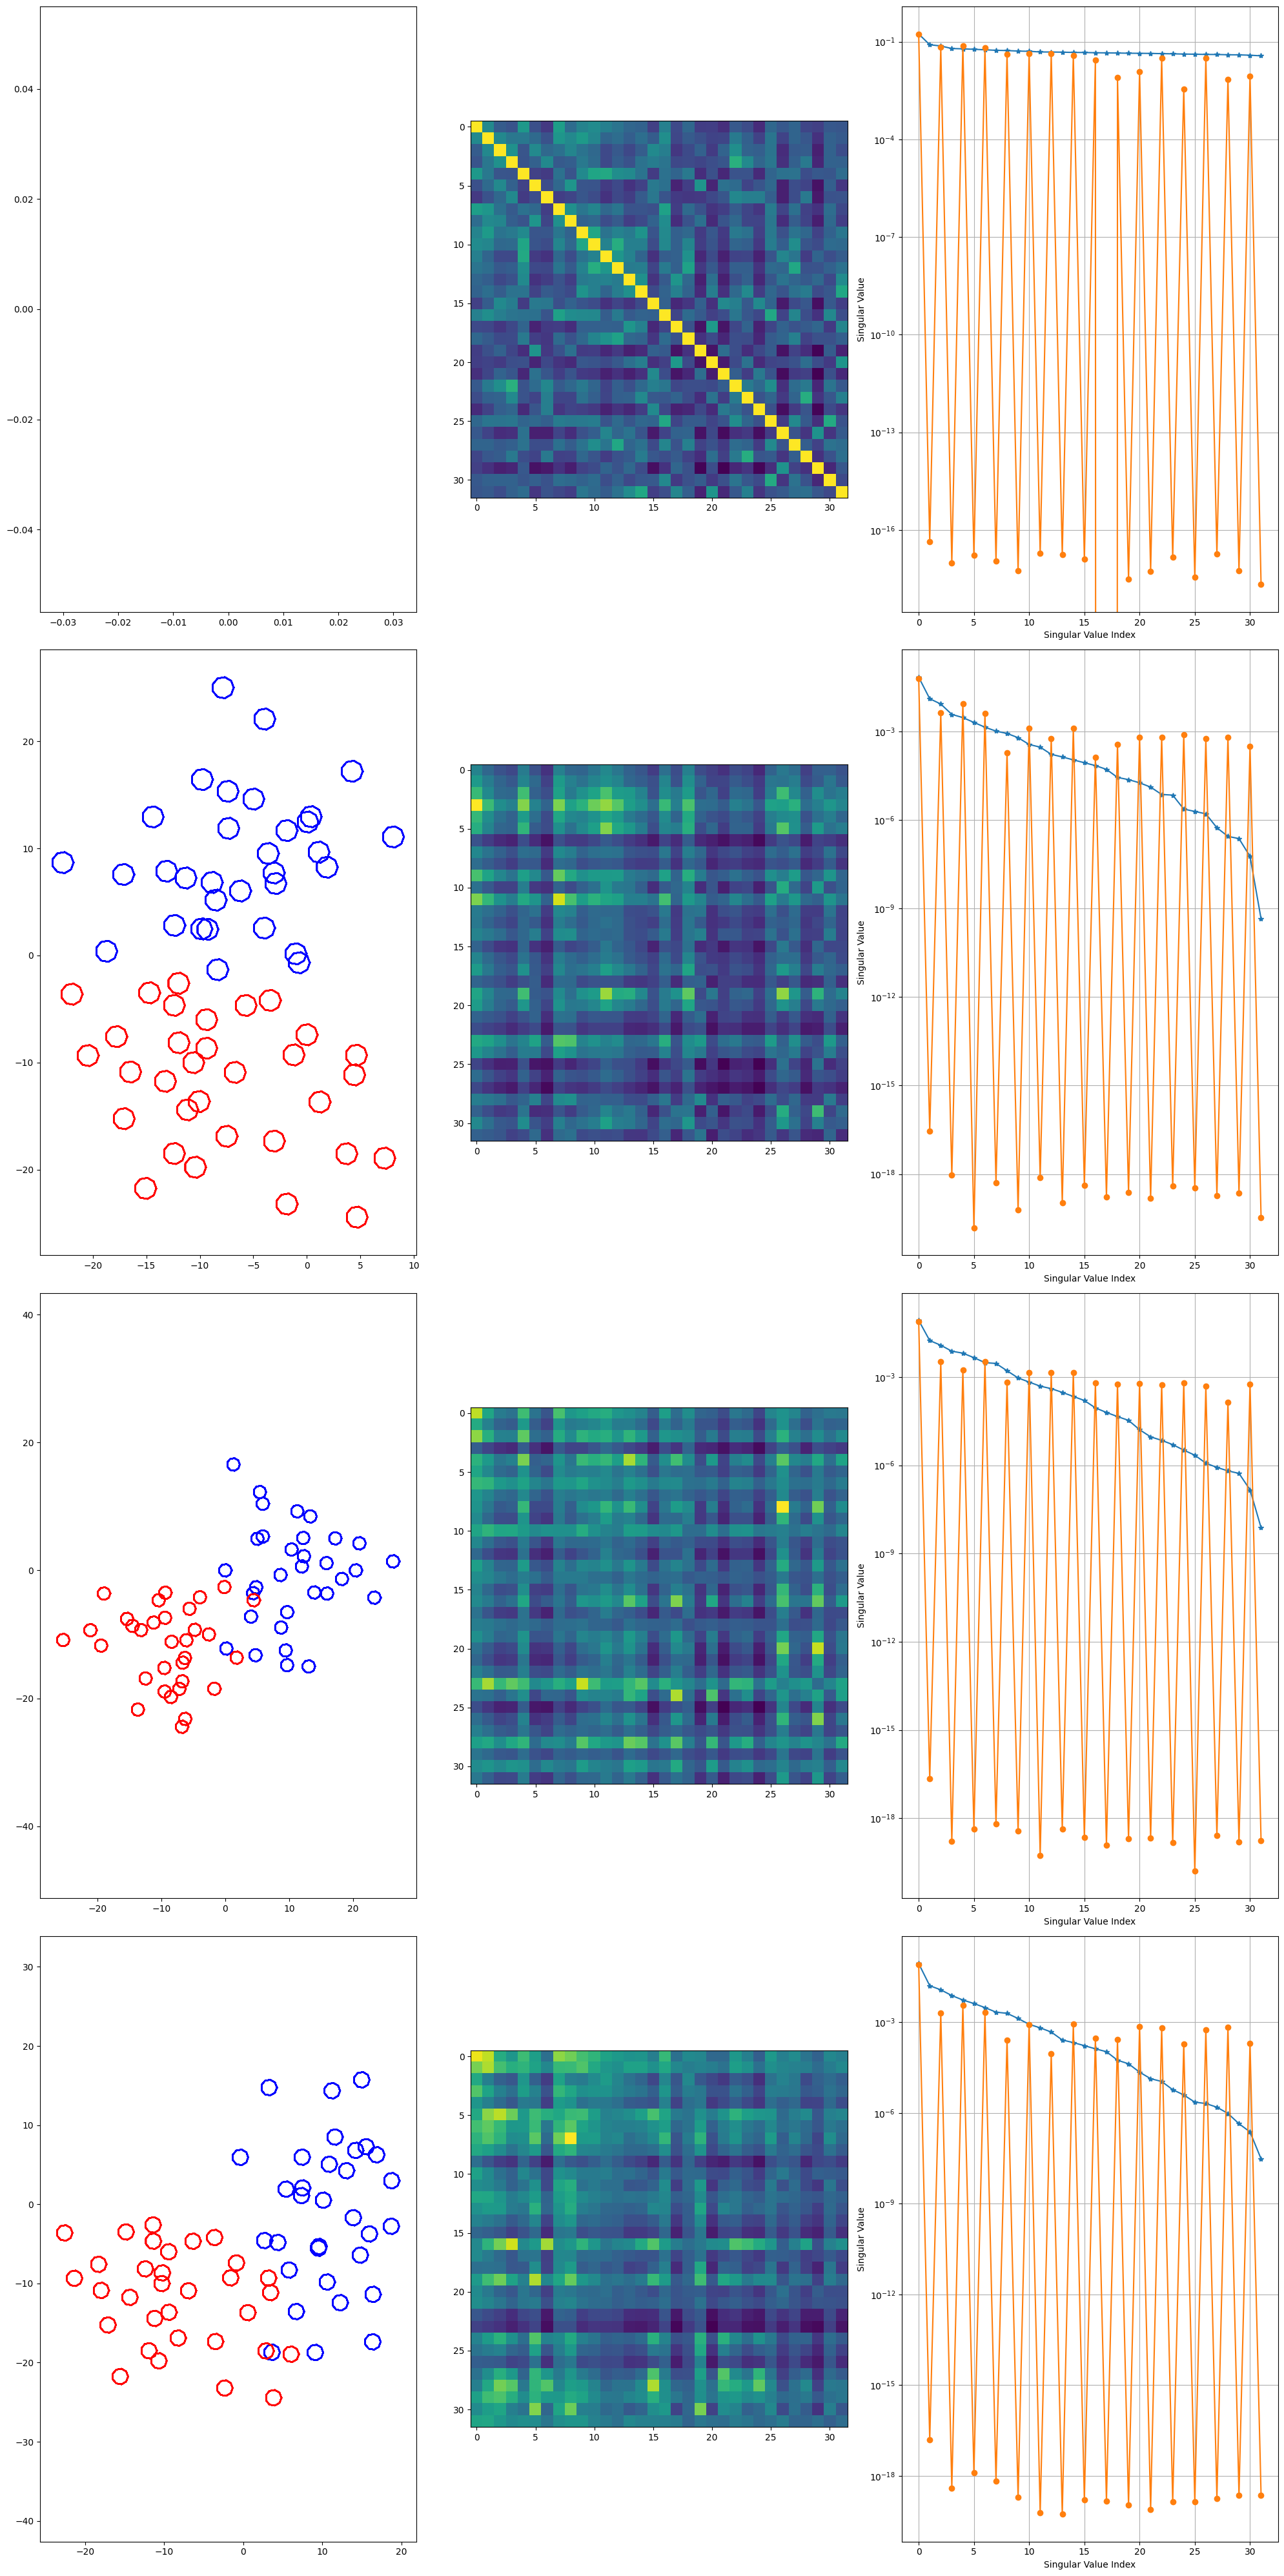

In [ ]:
def get_coeff(R, S, Mij):
    lhs = (R.conj().T @ R)*(S.conj().T @ S)
    rhs = jnp.sum(R.conj() * (Mij @ S), axis=0) 
    D = jnp.linalg.solve(lhs, rhs)
    return D

def get_coeff_greedy(R, S, Mij):
    K = R.shape[1]
    D = jnp.zeros((K,), dtype=R.dtype)
    for i in range(K):
        ri = R[:, i]
        si = S[:, i]
        lhs = jnp.linalg.norm(ri)**2 * jnp.linalg.norm(si)**2
        rhs = jnp.sum(ri.conj() * (Mij @ si), axis=0)
        D = D.at[i].set(rhs / lhs)
        Mij = Mij - jnp.outer(ri, si.conj()) * D[i]
    return D

def get_coeff_matrix_greedy(R, S, Mij):
    K = R.shape[1]
    D = jnp.zeros((K, K), dtype=R.dtype)
    dvec = []
    for ij_sum in range(2*K):
        for i in range(max(0, ij_sum - (K - 1)), min(K, ij_sum + 1)):
            j = ij_sum - i
            ri = R[:, i]
            si = S[:, j]
            lhs = jnp.linalg.norm(ri)**2 * jnp.linalg.norm(si)**2
            rhs = jnp.sum(ri.conj() * (Mij @ si), axis=0)
            D = D.at[i, j].set(rhs / lhs)
            dvec.append(rhs / lhs)
            Mij = Mij - jnp.outer(ri, si.conj()) * D[i, j]
    return D, jnp.array(dvec)

j = 0
plt.figure(figsize=(20, 40))
for i in range(num_balls):
    
    Mij, qi, qj = ball_pair_to_data(i, j)
    dqi = qi - qi.mean(axis=0)
    dqj = qj - qj.mean(axis=0)
    #Mij = ((dqi[:, None, 0] * dqj[None, :, 0])).astype(jnp.float64)
    
    #R, S = tensor_basis(dqi, dqj, 3)
    R = basis(dqi, 3, 'spherical_harmonics')
    S = basis(dqj, 3, 'spherical_harmonics')
    
    #print(Mij.shape)
    #R = jnp.eye(Mij.shape[0]) / jnp.linalg.norm(dqi, axis=1)[:,]
    #S = jnp.eye(Mij.shape[0])    
    U, E, Vh  = np.linalg.svd(Mij)
    
    option = 1
    match option:
        case 1:
            D, dvec = get_coeff_matrix_greedy(R, S, Mij)
        case 2:
            dvec = get_coeff_greedy(R, S, Mij)
            D = jnp.diag(dvec)                      
        case 3:
            dvec = get_coeff(R, S, Mij)
            D = jnp.diag(dvec)              
    
    #U2, E2, Vh2 = np.linalg.svd(Mij - R @ jnp.diag(D) @ S.T)
    #U2, E2, Vh2 = np.linalg.svd(Mij - (R * jnp.eye(R.shape[1])[:,1]) @ S.T)

    print(f"optimal: {frobenius(Mij - R @ D @ S.T)}")
    #print(f"analytic: {frobenius(Mij - (R * jnp.eye(R.shape[1])[1,:]) @ S.T)}")
    #t = np.arange(len(E)) / 6
    
    ax1 = plt.subplot(num_balls, 3, 3*i+1)
    scatter_wrap(ax1, qi, qj)
    ax1.axis("equal")

    ax2 = plt.subplot(num_balls, 3, 3*i+2)
    plt.imshow(jnp.log10(jnp.abs(Mij)))

    ax3 = plt.subplot(num_balls, 3, 3*i+3)
    plt.semilogy(E, '*-')
    plt.semilogy(jnp.abs(dvec), 'o-')
    #plt.semilogy(E2, 'o-')
    
    plt.xlabel("Singular Value Index")
    plt.ylabel("Singular Value")
    plt.grid()
    
plt.tight_layout()
plt.gcf().savefig("cluster_pairs.pdf", dpi=300)